In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import matplotlib.colors as mcolors

In [2]:
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mohsi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mohsi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mohsi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
data = pd.read_csv('train.txt/processed_papers.csv')

In [4]:
print(data.columns)
print(data.info())
print(data.isnull().sum())

Index(['paper_id', 'abstract'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   paper_id  15000 non-null  object
 1   abstract  15000 non-null  object
dtypes: object(2)
memory usage: 234.5+ KB
None
paper_id    0
abstract    0
dtype: int64


In [5]:
def cleaned_text(text):
    clean = re.sub("\n"," ",text)
    clean = clean.lower()
    clean = re.sub(r"[~.,%/:;?_&+*=!-]"," ",clean)
    clean = re.sub("[^a-z]"," ",clean)
    clean = clean.lstrip()
    clean = re.sub("\s{2,}"," ",clean)
    return clean

In [6]:
data['cleaned_abstract'] = data['abstract'].apply(cleaned_text)
data['cleaned_abstract'] = data['cleaned_abstract'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 3]))

In [7]:
# Stopword removal and lemmatization
stop = stopwords.words('english')
stop.append("also")

In [8]:
data['stop_removed_abstract'] = data['cleaned_abstract'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

In [9]:
data["tokenized"] = data['stop_removed_abstract'].apply(lambda x: nltk.word_tokenize(x))


In [10]:
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i, pos='v') for i in text]
    return lem_text

data['lemmatized'] = data['tokenized'].apply(word_lemmatizer)
data['lemmatize_joined'] = data['lemmatized'].apply(lambda x: ' '.join(x))

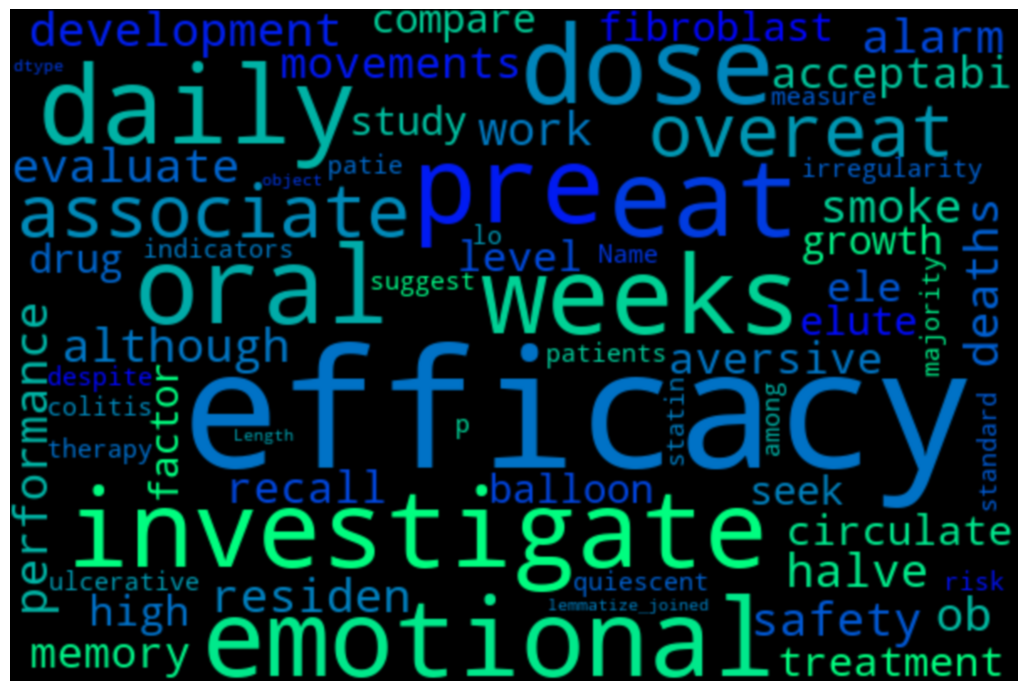

In [11]:
# Word cloud
cloud = WordCloud(colormap='winter', width=600, height=400).generate(str(data['lemmatize_joined']))
plt.figure(figsize=(13, 18))
plt.axis('off')
plt.imshow(cloud, interpolation='bicubic')
plt.show()


In [12]:
# Topic modeling using LDA
dictionary = corpora.Dictionary(data["lemmatized"])
doc_term_matrix = [dictionary.doc2bow(rev) for rev in data["lemmatized"]]

In [14]:
LDA = gensim.models.ldamodel.LdaModel

# Build LDA Model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=4, random_state=100, chunksize=200, passes=100)
lda_model.print_topics()

[(0,
  '0.039*"patients" + 0.015*"treatment" + 0.015*"group" + 0.011*"placebo" + 0.010*"study" + 0.010*"dose" + 0.008*"receive" + 0.007*"trial" + 0.007*"therapy" + 0.006*"months"'),
 (1,
  '0.014*"intervention" + 0.012*"group" + 0.011*"control" + 0.010*"study" + 0.008*"care" + 0.008*"participants" + 0.008*"trial" + 0.007*"health" + 0.006*"treatment" + 0.006*"use"'),
 (2,
  '0.014*"group" + 0.012*"level" + 0.012*"effect" + 0.012*"increase" + 0.012*"study" + 0.010*"control" + 0.009*"change" + 0.008*"blood" + 0.006*"weight" + 0.006*"placebo"'),
 (3,
  '0.050*"group" + 0.022*"patients" + 0.012*"pain" + 0.010*"treatment" + 0.010*"compare" + 0.009*"study" + 0.008*"control" + 0.008*"score" + 0.008*"use" + 0.007*"time"')]

In [15]:
# Checking thee coherence of the topics identified by LDA model
coherence_model_lda = CoherenceModel(model=lda_model, texts=data['lemmatized'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score: {coherence_lda}')

Coherence Score: 0.4017639939137215


In [16]:
# Visualizing topics
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

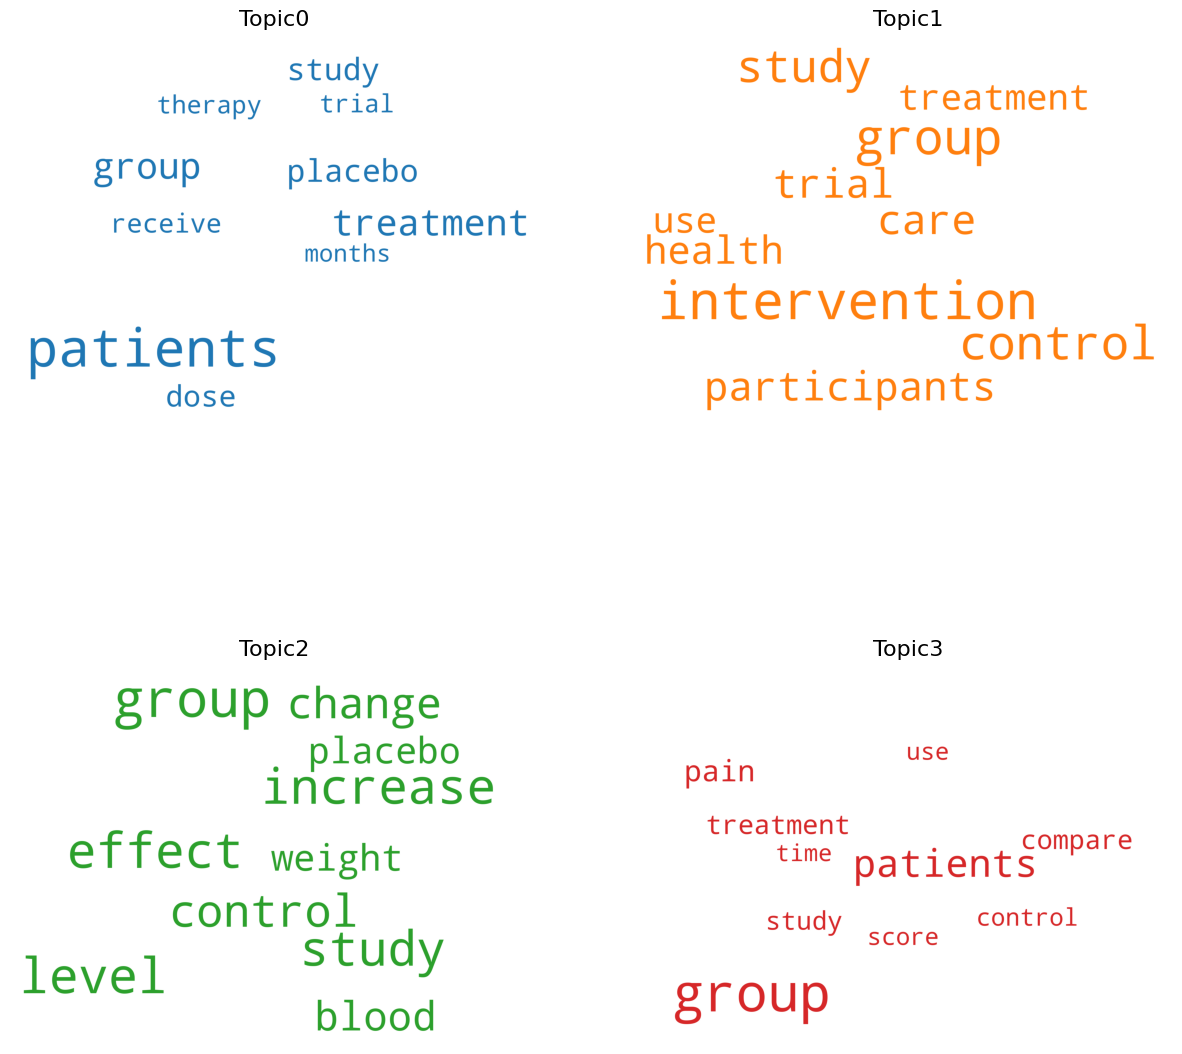

In [17]:
topics = lda_model.show_topics(formatted=False)
fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=250)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
plt.show()

In [18]:
# Dominant topic for each document
def format_topics_sentences(ldamodel=None, corpus=None, texts=data):
    sent_topics_df = pd.DataFrame()

    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = pd.concat([sent_topics_df, pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]])], ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [20]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=doc_term_matrix, texts=data["lemmatized"])
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
print(df_dominant_topic.head(10))
df_dominant_topic.to_csv("df_dominant_topic.csv")

   Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0               3              0.3789   
1            1               1              0.6516   
2            2               1              0.9680   
3            3               3              0.5395   
4            4               1              0.9028   
5            5               1              0.9931   
6            6               2              0.3937   
7            7               0              0.7202   
8            8               0              0.6808   
9            9               1              0.4429   

                                            Keywords  \
0  group, patients, pain, treatment, compare, stu...   
1  intervention, group, control, study, care, par...   
2  intervention, group, control, study, care, par...   
3  group, patients, pain, treatment, compare, stu...   
4  intervention, group, control, study, care, par...   
5  intervention, group, control, study, care, par...   
6  group, lev

In [22]:
# Plot word count and importance of topic keywords
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data["lemmatized"] for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i, weight, counter[word]])

In [27]:
topics

[(0,
  [('patients', 0.03909705),
   ('treatment', 0.0149924215),
   ('group', 0.014758096),
   ('placebo', 0.010572368),
   ('study', 0.010349773),
   ('dose', 0.00950871),
   ('receive', 0.0075028315),
   ('trial', 0.0067794784),
   ('therapy', 0.006659909),
   ('months', 0.0061518946)]),
 (1,
  [('intervention', 0.013931521),
   ('group', 0.012175111),
   ('control', 0.011049495),
   ('study', 0.010020916),
   ('care', 0.0082820915),
   ('participants', 0.007921112),
   ('trial', 0.007886653),
   ('health', 0.007225438),
   ('treatment', 0.0061423597),
   ('use', 0.006110903)]),
 (2,
  [('group', 0.01389774),
   ('level', 0.012074632),
   ('effect', 0.011880369),
   ('increase', 0.011866588),
   ('study', 0.011616216),
   ('control', 0.009869031),
   ('change', 0.008961666),
   ('blood', 0.007922639),
   ('weight', 0.006395435),
   ('placebo', 0.006351544)]),
 (3,
  [('group', 0.04967701),
   ('patients', 0.022285676),
   ('pain', 0.012268896),
   ('treatment', 0.0100300945),
   ('c

C:\Users\mohsi\AppData\Local\Temp\ipykernel_13032\1575042847.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
C:\Users\mohsi\AppData\Local\Temp\ipykernel_13032\1575042847.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
C:\Users\mohsi\AppData\Local\Temp\ipykernel_13032\1575042847.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
C:\Users\mohsi\AppData\Local\Temp\ipykernel_13032\1575042847.py:14: UserWarning: set_ticklabels() should only be used wit

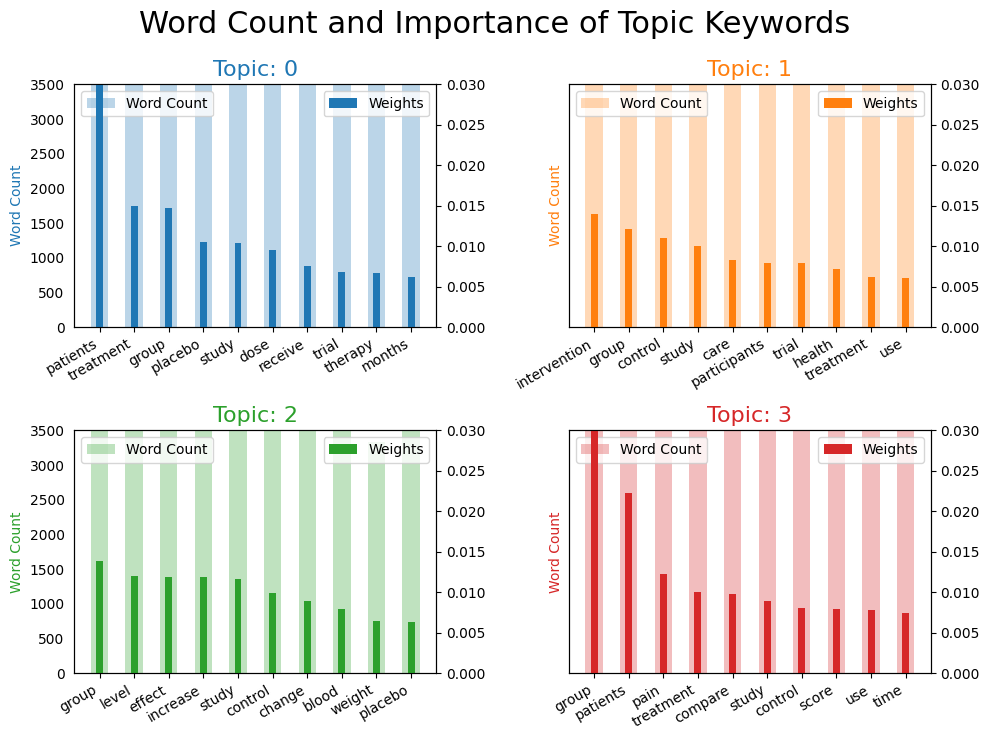

In [26]:
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharey=True, dpi=100)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030)
    ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
    ax.legend(loc='upper left')
    ax_twin.legend(loc='upper right')
    
fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

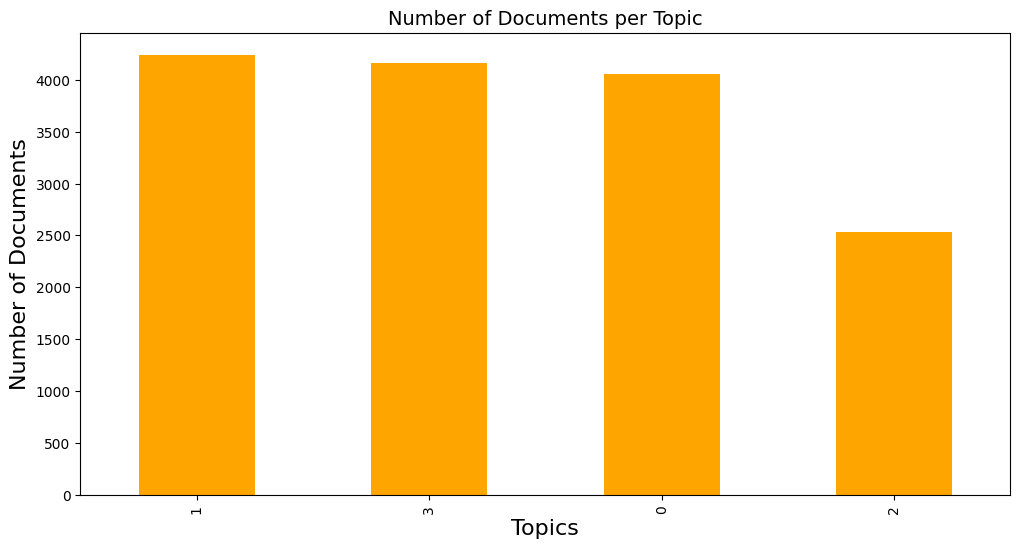

In [28]:
# Number of documents per topic
topic_counts = df_dominant_topic['Dominant_Topic'].value_counts()
plt.figure(figsize=(12, 6))
topic_counts.plot(kind='bar', color='orange')
plt.title("Number of Documents per Topic", size=14)
plt.xlabel("Topics", size=16)
plt.ylabel("Number of Documents", size=16)
plt.show()